In [1]:
# Imports
from env import host, user, password
import os

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from scipy import stats

import matplotlib.pyplot as plt
import seaborn as sns

import wrangle_zillow as w

np.random.seed(42)

In [2]:
df = w.wrangle_zillow()

csv file found and read
Incoming dataframe to remove_outliers had 50779 rows.
Returned dataframe from remove_outliers has 41918 rows.


In [3]:
df.head()

,property_value,logerror,square_feet,lot_size_sqft,bathrooms,has_halfbath,bedrooms,rooms,has_hottub,has_pool,...,year_built,years_tax_delinquent,bldg_quality_score,lat,long,county,city_id,zip_code,county_Orange,county_Ventura
0,1023282,0.025595,3100,4506,3,1,4,0,0,0,...,1998,0,NaN,33.634931,-117.869207,Orange,53571,96978,1,0
1,464000,0.055619,1465,12647,1,0,2,5,0,0,...,1967,0,NaN,34.449266,-119.281531,Ventura,13091,97099,0,1
2,564778,0.005383,1243,8432,2,0,3,6,0,1,...,1962,0,NaN,33.886168,-117.823170,Orange,21412,97078,1,0
3,145143,-0.103410,2376,13038,3,0,4,0,0,1,...,1970,0,8.0,34.245180,-118.240722,LA,396551,96330,0,0
7,218552,0.101723,738,4214,1,0,2,0,0,0,...,1922,0,5.0,34.149214,-118.239357,LA,45457,96325,0,0


SUMMARY REPORT
          
          
Dataframe head: 
   property_value  logerror  square_feet  lot_size_sqft  bathrooms  \
0         1023282  0.025595         3100           4506          3   
1          464000  0.055619         1465          12647          1   
2          564778  0.005383         1243           8432          2   

   has_halfbath  bedrooms  rooms  has_hottub  has_pool  ... year_built  \
0             1         4      0           0         0  ...       1998   
1             0         2      5           0         0  ...       1967   
2             0         3      6           0         1  ...       1962   

  years_tax_delinquent  bldg_quality_score        lat        long   county  \
0                    0                 NaN  33.634931 -117.869207   Orange   
1                    0                 NaN  34.449266 -119.281531  Ventura   
2                    0                 NaN  33.886168 -117.823170   Orange   

   city_id  zip_code county_Orange  county_Ventura  
0 

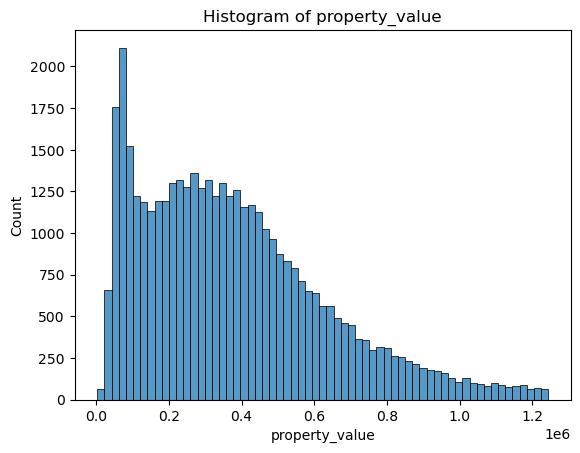

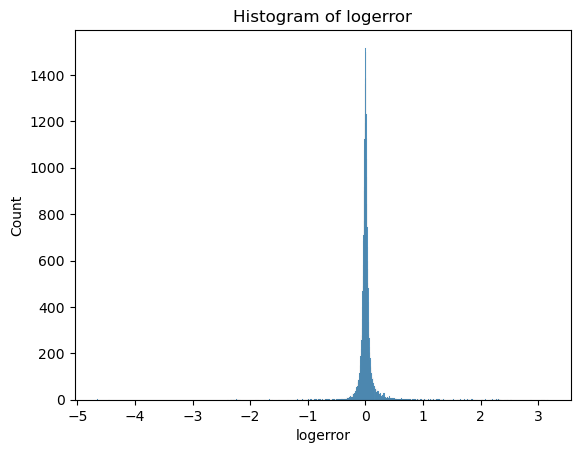

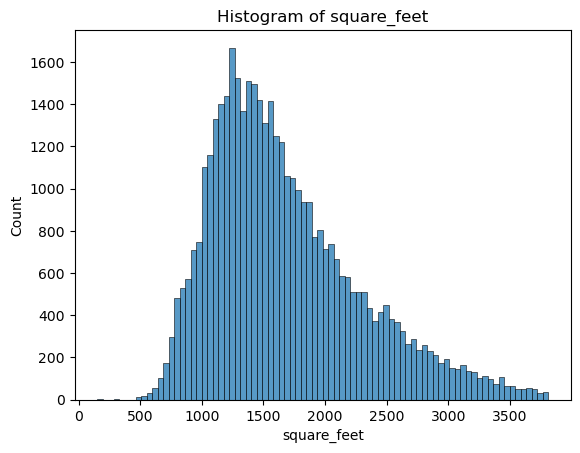

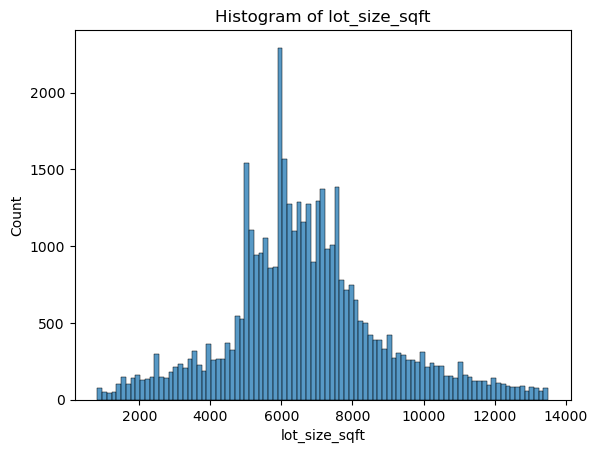

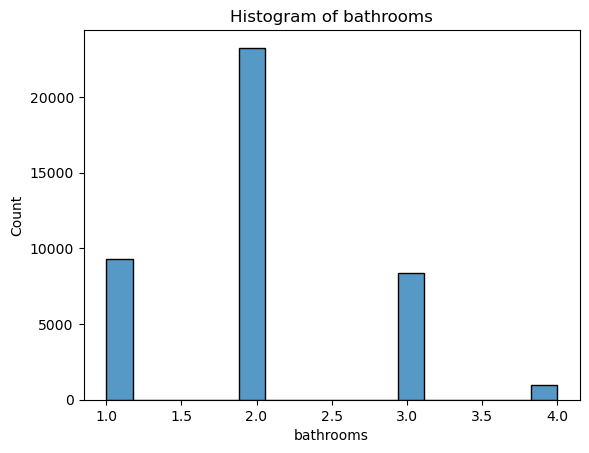

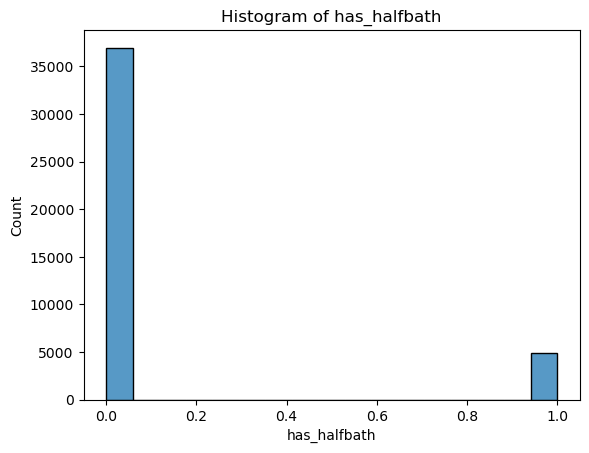

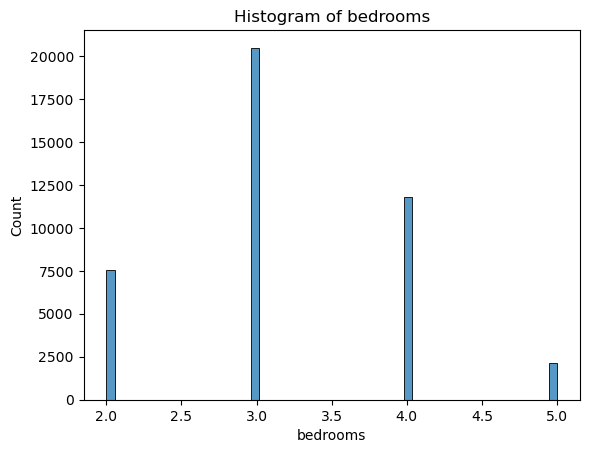

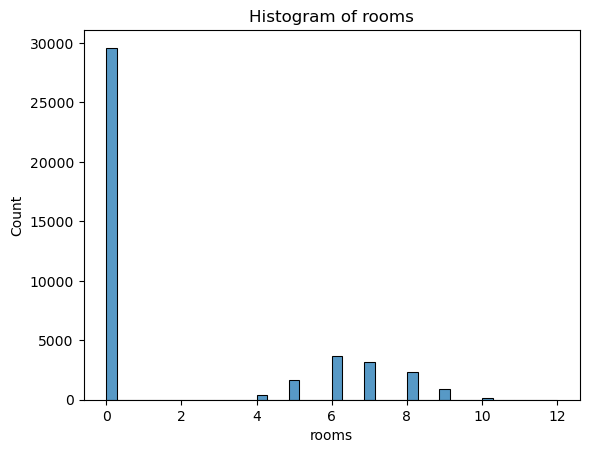

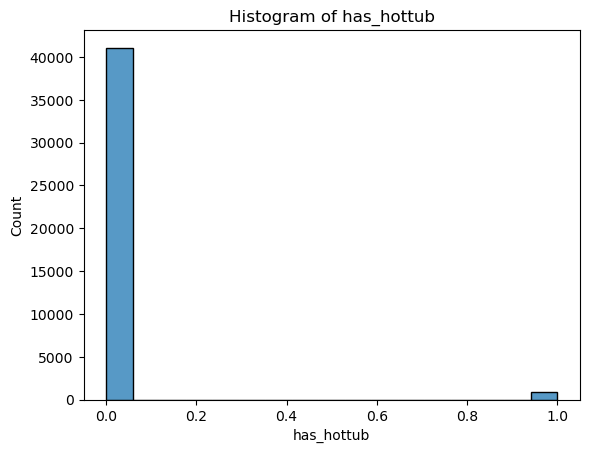

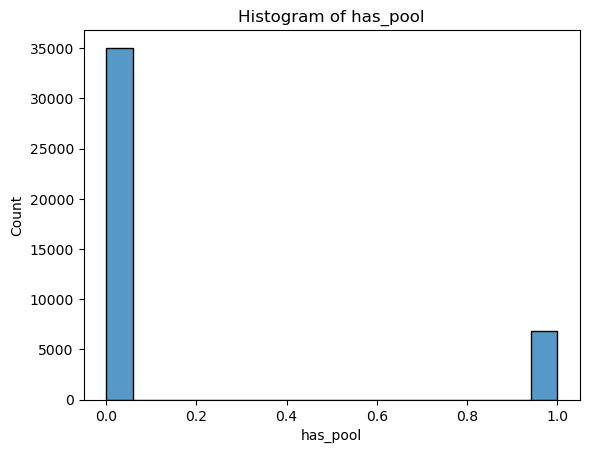

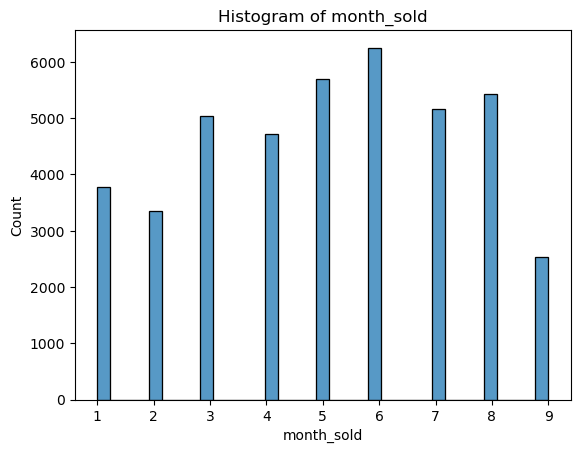

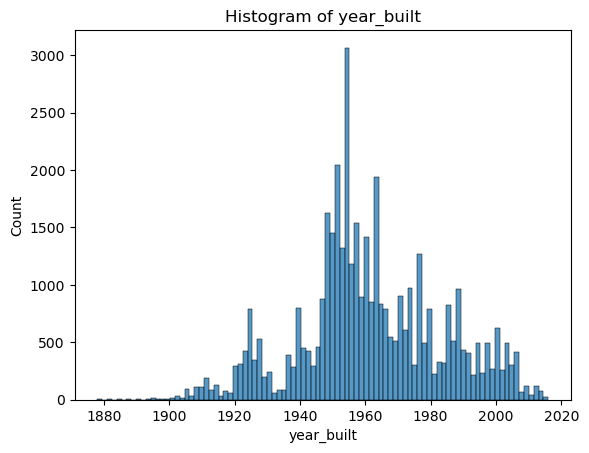

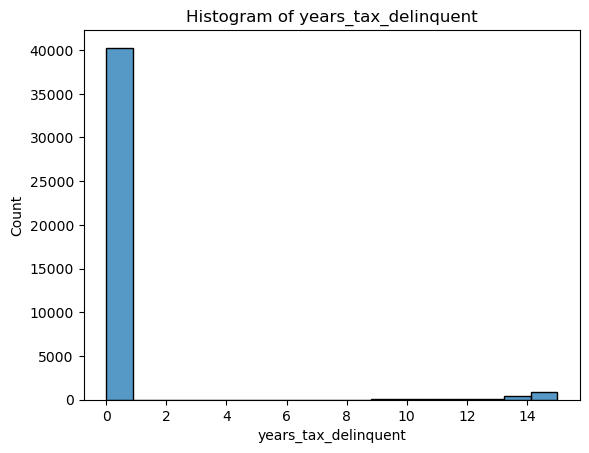

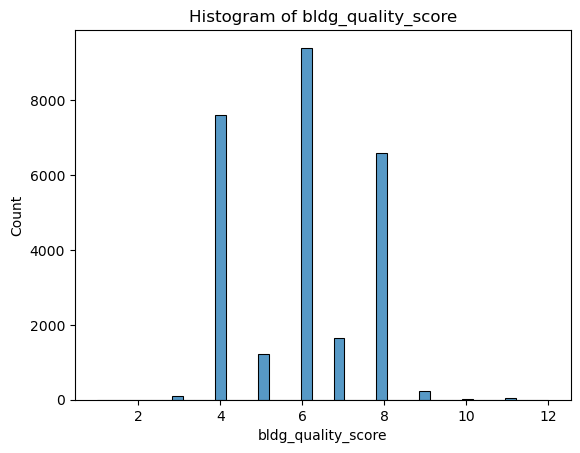

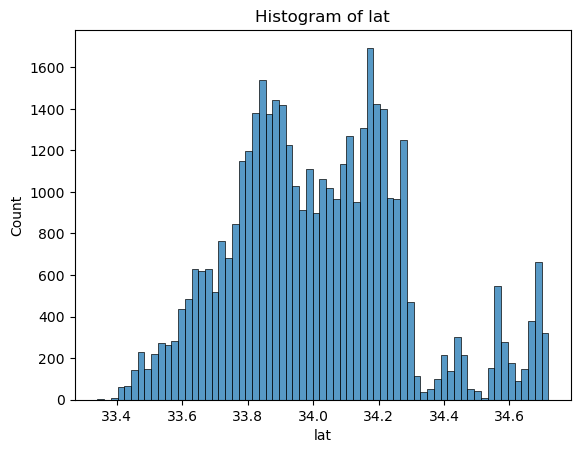

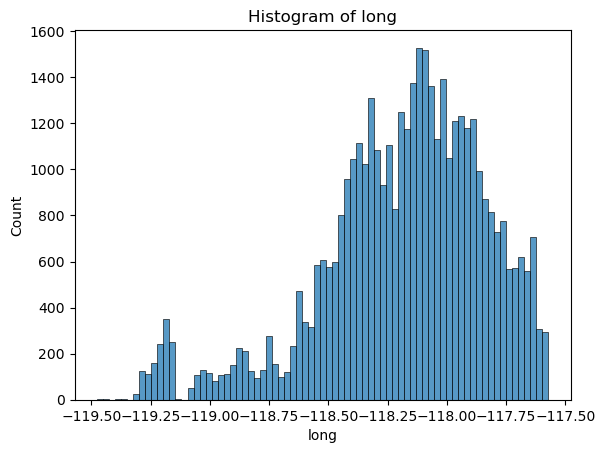

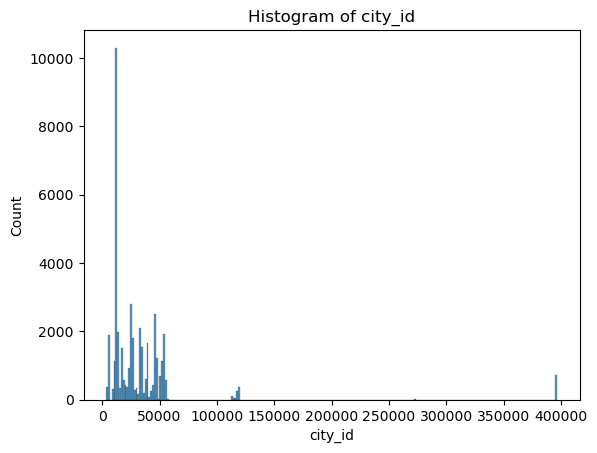

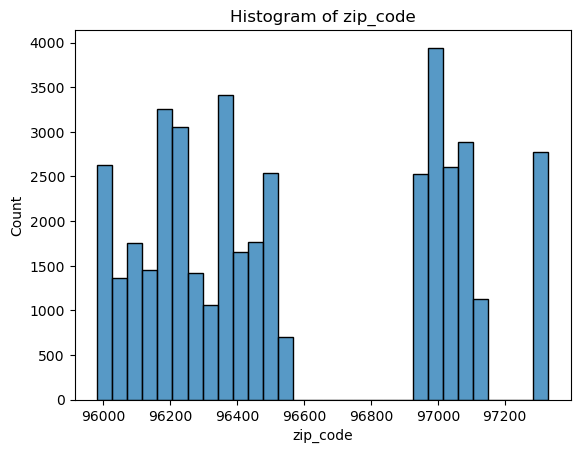

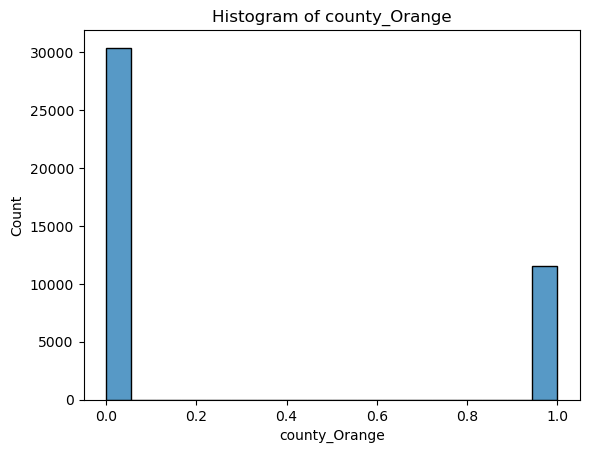

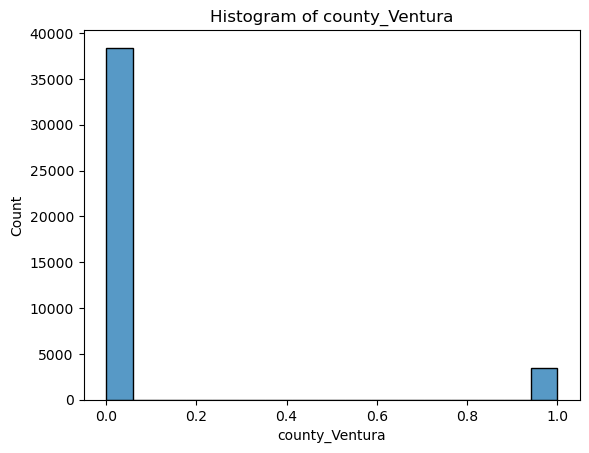

In [4]:
w.summarize(df)

In [ ]:
##### EVERYTHING BELOW WAS LEADING UP TO THE wrangle_zillow function above

In [ ]:
# check to make sure my sql query did not return any duplicated rows
df.duplicated().sum()

In [ ]:
# check for and drop rows with nulls in latitude longitude per exercise instructions
df = df.loc[~(df.latitude.isnull())]
print(df.latitude.isnull().sum())
print(df.longitude.isnull().sum())

In [ ]:
# w.summarize(df)

In [ ]:
# Remove any properties that are not single unit properties; 
# I'll use 'Single Family Residential' in the propertylandusedesc column
df = df[df.propertylandusedesc=='Single Family Residential']

In [ ]:
df.unitcnt.isnull().sum()

In [ ]:
# There are 27 rows with unitcnt > 1 and 18558 rows that are null
# I will replace the nulls with 1 and remove the rows with a value > 1
# Then I'll remove the row (below) because they're all the same
df.unitcnt = df.unitcnt.fillna(1)
df = df[df.unitcnt<=1]

In [ ]:
df.unitcnt.isnull().sum()

In [ ]:
# after viewing taxdelinquencyyear, I am making an assumption that null values 
# should be replaced with 0 (i.e. 0 years delinquent on taxes)
df.taxdelinquencyyear = df.taxdelinquencyyear.fillna(0)
df.taxdelinquencyyear.isnull().sum()

In [ ]:
# made an assumption that if poolcnt was null, it should be 0 (no pool)
df.poolcnt = df.poolcnt.fillna(0)
df.poolcnt.isnull().sum()

In [ ]:
# made an assumption that if hashottubeorspa was null, it should be 0 (no hottub)
df.hashottuborspa = df.hashottuborspa.fillna(0)
df.hashottuborspa.isnull().sum()

In [ ]:
# some google searching said less than half of homes in Los Angeles have air conditioning. 
# So, I'm replacing the nulls with None. Since Wall Unit is only 16 rows, I'm changing those to 'Yes'
df.airconditioningdesc = df.airconditioningdesc.fillna('None')
df.airconditioningdesc = df.airconditioningdesc.map({'None': 'None', 'Central': 'Central', 'Yes': 'Yes', 'Wall Unit': 'Yes'})
df.airconditioningdesc.isnull().sum()

In [ ]:
# heatingorsystemdesc has a good amount of non-nulls, so I'm just going to add an "Other" entry for the nulls
df.heatingorsystemdesc = df.heatingorsystemdesc.fillna('Other')
df.heatingorsystemdesc.isnull().sum()

In [ ]:
# transactiondate is a string like '2017-01-01'; I am binning all these value into the month, i.e. a value 1-12
df['month_sold'] = df.transactiondate.str[5:7].astype(int)

In [ ]:
# garagecarcnt and garagetotalsqft had a higher percentage of null values than really made sense;
# I let them drop along with others that had more than 60% nulls in the column or 75% nulls in the row
df = w.handle_missing_values(df, .6, .75)

In [ ]:
df.shape

In [ ]:
# Drop any remain columns that won't help, i.e. the 'id' columns and a few others listed here:
# - propertyzoningdesc was not decipherable: LAR1 appeared to be the R1 category in LA county, but there were many others
#   that didn't make sense. Also, the LA RA category is supposed to have a lot size of at least 17,500 square feet 
#   and R1 was at least 5000 square feet which leads me to believe squarefeet will cover the info in this column
# - unitcnt is now all 1.0, so not useful
# - assessmentyear was all 2016, not useful
# - dropping census columns; kept regionidcity, and regionidzip for further exercise
# - I hypothesize lat/long will be more useful for clustering

# And dropping columns that are repeated columns under different names 
# - finishedsquarefeet12 is the same as calculated finishedsquarefeet
# - calculatedbathnbr is the same as bathroomcnt
# - fullbathcnt is practically the same as bathroomcnt
# - dropped rawcensustractandblock, but kept censustractandblock for now
# - regionidcounty maps with fips; keeping fips and dropping county
# - dropped transactiondate since I made a new column month_sold
# - dropped taxdelinquencyflag because taxdelinquencyyear has 0 for those homes not delinquent

# and dropping the columns we're not supposed to use like taxamount

# need more investigation:
# - roomcnt : this column has ~36K rows with the value 0. The rest are normally distributed. Makes me think the 0's are really just nulls

drop_cols = ['propertylandusetypeid', 'heatingorsystemtypeid', 'parcelid', 'id', 'propertycountylandusecode', 'propertyzoningdesc'
             , 'rawcensustractandblock', 'structuretaxvaluedollarcnt', 'assessmentyear', 'landtaxvaluedollarcnt', 'taxamount'
             , 'finishedsquarefeet12', 'calculatedbathnbr', 'fullbathcnt', 'unitcnt', 'propertylandusedesc'
             , 'regionidcounty', 'censustractandblock', 'transactiondate']
df = df.drop(columns=drop_cols)

In [ ]:
# for buildingqualitytypeid, there are enough non-nulls, I will keep it, but I'll need to impute it after train/val/test split
# For the rest, I want to remove the rows that have null values as there won't be that many
df = df.dropna(subset=df.columns.difference(['buildingqualitytypeid']))

In [ ]:
# outliers: 1. remove any rows with bathroomcnt < 1
df = df[df.bathroomcnt >= 1]

In [ ]:
# outliers: 2. remove any rows with bedroomcnt < 1
df = df[df.bedroomcnt >= 1]

In [ ]:
# feature engineering: make a has_halfbath
# and since it is related to bathroomcnt, make bathroomcnt an integer (3.5 becomes 3, with has_halfbath = 1 (True))
df['has_halfbath'] = ((df.bathroomcnt % 1) == .5)
df.has_halfbath = df.has_halfbath.astype(int)
df.bathroomcnt = df.bathroomcnt.astype(int)

In [ ]:
# change the column names to something more meaningful and easier to use
columns = ['logerror', 'bathrooms', 'bedrooms', 'bldg_quality_score', 'square_feet'
           , 'county', 'has_hottub', 'lat', 'long', 'lot_size_sqft'
           , 'has_pool', 'city_id', 'zip_code', 'rooms', 'year_built', 'property_value', 'years_tax_delinquent'
           , 'ac_type', 'heating_type', 'month_sold', 'has_halfbath']
df.columns = columns

In [ ]:
# change county (formerly fips) to map to the correct county
df.county = df.county.map({6037: 'LA', 6059: 'Orange', 6111: 'Ventura'})

In [ ]:
# change lat/long to the format degrees.decimal_degrees
df.lat = df.lat / 1_000_000
df.long = df.long / 1_000_000

In [ ]:
# change many float columns to ints
intcolumns = ['bedrooms', 'square_feet', 'has_hottub', 'lot_size_sqft'
              , 'has_pool', 'city_id', 'zip_code', 'rooms', 'year_built', 'property_value'
              , 'years_tax_delinquent']
df[intcolumns] = df[intcolumns].astype(int)

In [ ]:
# w.summarize(df)
# outliers: 3. after univariate visualization, 4 columns have significant outliers:
# - bathrooms, bedrooms, square_feet, lotsize_sqft, property_value, years_tax_delinquent

In [ ]:
outlier_columns = ['bathrooms', 'bedrooms', 'square_feet', 'lot_size_sqft', 'property_value']
df = w.remove_outliers(df, outlier_columns)

In [ ]:
ordered_columns = ['property_value', 'logerror', 'square_feet', 'lot_size_sqft', 'bathrooms'
                   , 'has_halfbath', 'bedrooms', 'rooms', 'has_hottub', 'has_pool', 'ac_type'
                   , 'heating_type', 'month_sold', 'year_built'
                   , 'years_tax_delinquent', 'bldg_quality_score', 'lat', 'long', 'county', 'city_id'
                   , 'zip_code']
df = df[ordered_columns]
#df.head().T

In [ ]:
df.zip_code[df.zip_code > 99999]
df = df[df.zip_code <= 99999]
df.shape

In [ ]:
dummy_df = pd.get_dummies(df[['city_id']], drop_first=True)
dummy_df.info()


In [ ]:
df.info()

In [ ]:
w.summarize(df)